Data Source: https://www.kaggle.com/datasets/erdemtaha/cancer-data

In [1]:
# Data Preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde

# Modelling
np.random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [283]:
df = pd.read_csv("data/Cancer_Data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

The dataset is a 569x33 table. The 33 columns comprise of id (tumor id), diagnosis (classification label), 30 characteristics of the tumor, and an "Unnamed" column that is entirely null. The id and Unnamed columns will be dropped to result in a 569x30 table. All features are floating values and thus do not need to be made numerical. No other datapoints need to be dropped or filled - data is fully preprocessed.

In [285]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [286]:
df = df.drop(columns = ["id", "Unnamed: 32"])
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Further analysis

In [288]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


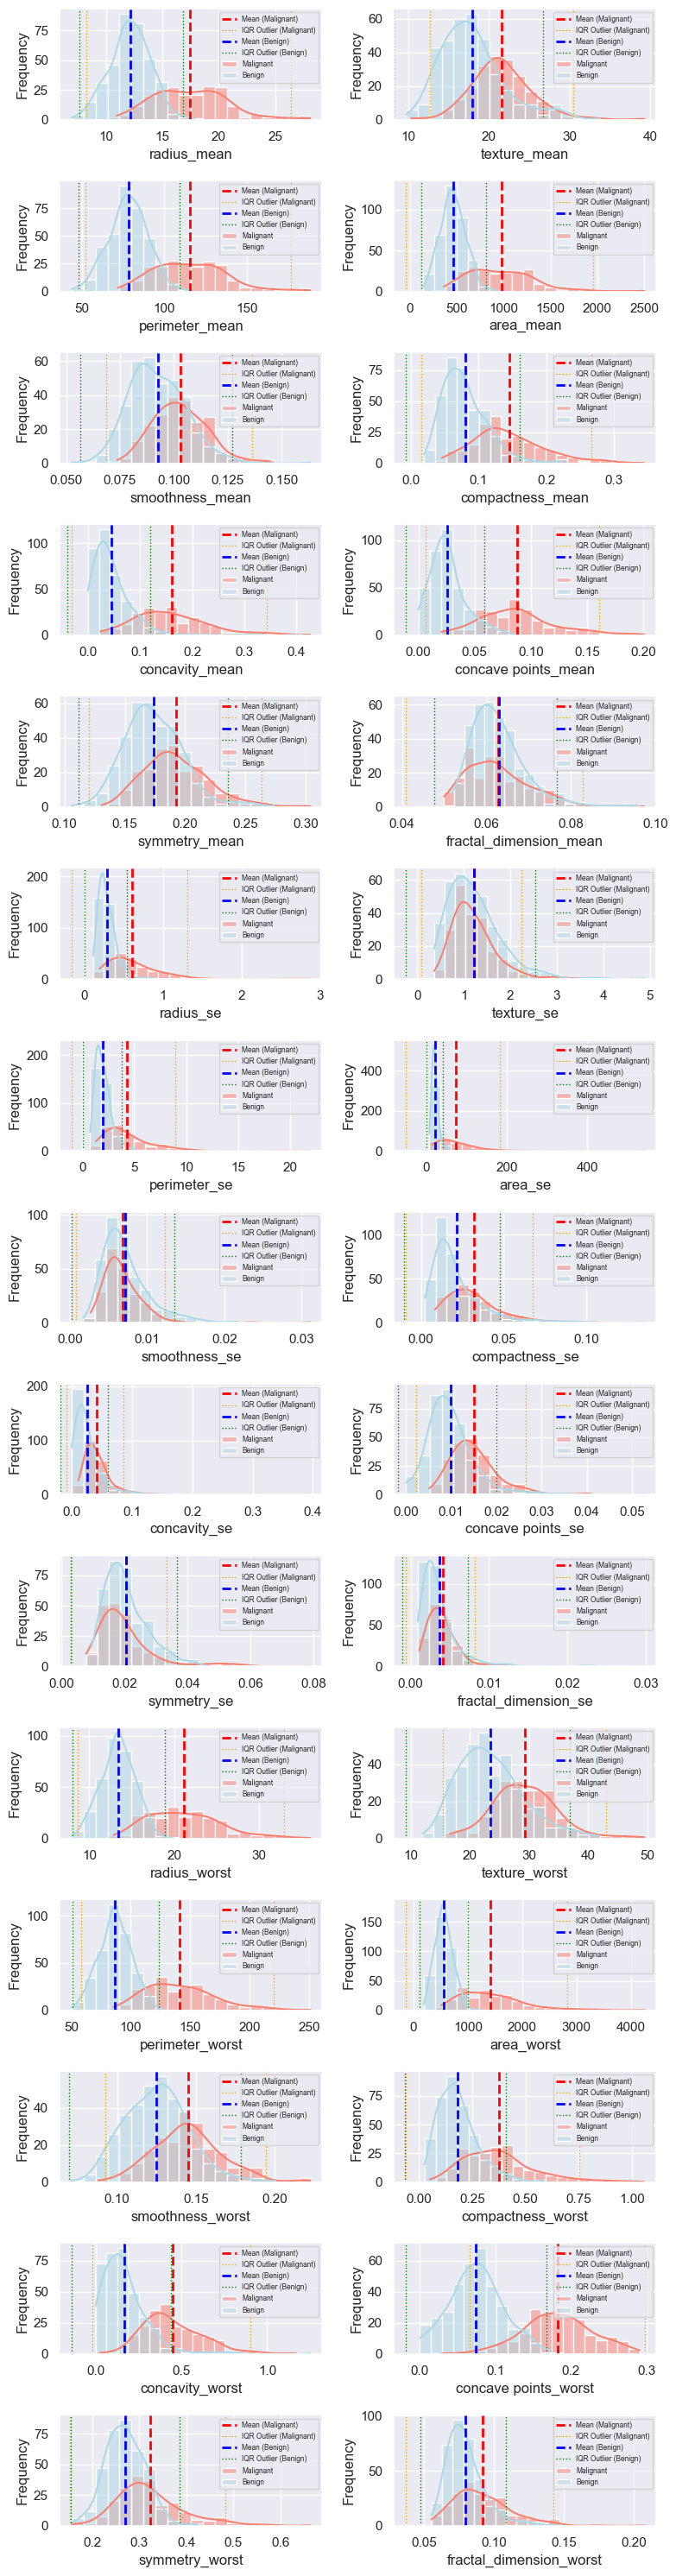

In [289]:
# Enumerate through columns and create a histogram for each

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=15, figsize=(8,30), dpi=100)
ax = ax.flatten()

# Plot histograms with Gaussian curve for each column (excluding "diagnosis")
for i, col in enumerate(df.drop(columns="diagnosis").columns):
    # Define data arrays
    malignant_data = df[df["diagnosis"] == 'M'][col]
    benign_data = df[df["diagnosis"] == 'B'][col]
    
    # Calculate common bin edges for the current column
    combined_data = np.concatenate([malignant_data, benign_data])
    bin_edges = np.histogram_bin_edges(combined_data, bins=20)
    
    # Plot histograms
    sns.histplot(malignant_data, color="salmon", label='Malignant', kde=True, ax=ax[i], bins=bin_edges)
    sns.histplot(benign_data, color="lightblue", label='Benign', kde=True, ax=ax[i], bins=bin_edges)
    ax[i].set(xlabel=col, ylabel="Frequency")
    
    # Calculate mean and IQR outliers
    mean_malignant = malignant_data.mean()
    mean_benign = benign_data.mean()
    q1_malignant = malignant_data.quantile(0.25)
    q3_malignant = malignant_data.quantile(0.75)
    iqr_malignant = q3_malignant - q1_malignant
    lo_thres_malignant = q1_malignant - 1.5*iqr_malignant
    hi_thres_malignant = q3_malignant + 1.5*iqr_malignant   
    
    q1_benign = benign_data.quantile(0.25)
    q3_benign = benign_data.quantile(0.75)
    iqr_benign = q3_benign - q1_benign
    lo_thres_benign = q1_benign - 1.5*iqr_benign
    hi_thres_benign = q3_benign + 1.5*iqr_benign
    
    # Draw vertical lines for mean and IQR outliers
    ax[i].axvline(mean_malignant, color='red', linestyle='dashed', linewidth=2, label='Mean (Malignant)')
    ax[i].axvline(hi_thres_malignant, color='orange', linestyle='dotted', linewidth=1, label='IQR Outlier (Malignant)')
    ax[i].axvline(lo_thres_malignant, color='orange', linestyle='dotted', linewidth=1)
    
    ax[i].axvline(mean_benign, color='blue', linestyle='dashed', linewidth=2, label='Mean (Benign)')
    ax[i].axvline(hi_thres_benign, color='green', linestyle='dotted', linewidth=1, label='IQR Outlier (Benign)')
    ax[i].axvline(lo_thres_benign, color='green', linestyle='dotted', linewidth=1)

    # Legend
    ax[i].legend(fontsize=6)
    
plt.tight_layout()
plt.show()


Some characteristics such as concavity and worst radius appear to exhibit significant differences in distribution between malignant and benign tumors, whereas others such as fractal dimension and texture appear to be indistinguishable from one another. Outliers as defined by the IQR are present in the dataset; these will be kept for baseline but may need to be removed during model tuning. Statistically insignificant dataset and noncorrelative characteristics demonstrated by p-values of t-test and correlation coefficients also may need to be dropped from the dataset during model tuning.

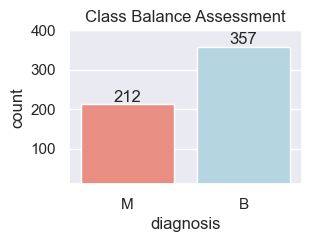

In [290]:
fig, ax = plt.subplots(figsize=(3, 2))
ax = sns.countplot(x="diagnosis", data=df, palette=["salmon","lightblue"])

for container in ax.containers:
    ax.bar_label(container)
    
ax.set(title="Class Balance Assessment", ylim=(10, 400))
plt.show()

In [291]:
minority_proportion = df[df["diagnosis"] == "M"].count()[0]/len(df)
minority_proportion

0.37258347978910367

There is class imbalance with the benign tumor class making up only 37% of the entire dataset. During the model tuning process, the data may need to be resampled using SMOTE.

In [292]:
df["diagnosis"] = df["diagnosis"].replace({"M": 1, "B": 0}) # Added after first roadblock in modelling

from sklearn import preprocessing

# Shuffle the data
df_shuffled = df.sample(frac=1)

# Define X and scale data to 0 mean
scaler = preprocessing.StandardScaler()
X = df_shuffled.drop(columns = "diagnosis").values
X = scaler.fit_transform(X)

# Define y
y = df_shuffled["diagnosis"]

# Split training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [293]:
# <100K samples
# recommend LinearSVC, KNeighbors Classifer by Scikit Learn
# also try RandomForestClassifier, LogisticRegression

# note: tried LinearSVC. prompted to increase interations due to failed convergence. 
#                        from 1,000 to 1,000,000 still no convergence. suggests to scale data to 0 mean using StandardScaler()
#                        no errors after scaling to 0 mean.
# note: tried KNeighbors. error showed that KNN does not have a score method. typically used for unsupervised learning. 
#                         will try sklearn.metrics.accuracy_score. error showed that KNN does not have predict method. 
#                         deleted "KNN": NearestNeighbors() from model dict

# from sklearn.svm import LinearSVC
# from sklearn.neighbors import NearestNeighbors // DELETED
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

In [294]:
def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=True)
    plt.xlabel("Predicted label") # model preds
    plt.ylabel("True label") # true labels 

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        65
           1       0.98      0.94      0.96        49

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



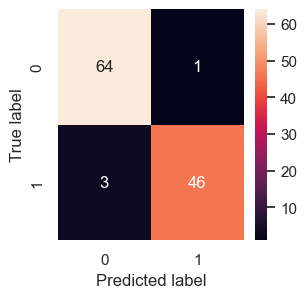

In [295]:
model = LinearSVC()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"LinearSVC \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)

RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        65
           1       0.94      0.90      0.92        49

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



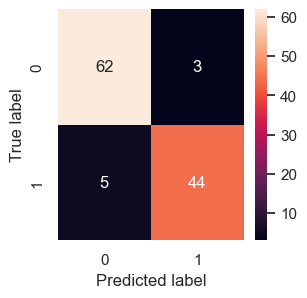

In [296]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"RandomForestClassifier \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)

LogisticRegression 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        65
           1       1.00      0.96      0.98        49

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



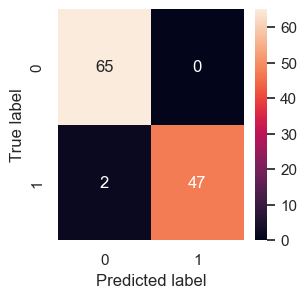

In [297]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"LogisticRegression \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)

Tuning the model by:
Remove IQR outliers
Remove noncorrelative characteristics (p-values of t-test b/w M and B, p-values of correlation coeff)
Resampled using SMOTE
Hyperparameter tuning

In [42]:
df = pd.read_csv("data/Cancer_Data.csv")

In [43]:
df = df.drop(columns = ["id", "Unnamed: 32"])
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [44]:
# create two dfs, one for malignant and one for benign
df_malignant = df[df["diagnosis"]=="M"].drop(columns=["diagnosis"])
df_benign = df[df["diagnosis"]=="B"].drop(columns=["diagnosis"])

In [63]:
# Calculate outliers for each column in malignant df, remove them and verify
outlier_count_mal = {}
df_mal_no_outlier = {}
for key, df_col in df_malignant.items():
    mean = df_col.mean()
    q1 = df_col.quantile(0.25)
    q3 = df_col.quantile(0.75)
    iqr = q3 - q1
    lo_thres = q1 - 1.5 * iqr
    hi_thres = q3 + 1.5 * iqr
    
    outlier_count_mal[key] = df_col[(df_col < lo_thres) | (df_col > hi_thres)].count()
    df_mal_no_outlier[key] = df_col.where((df_col >= lo_thres) & (df_col <= hi_thres))
    
combined_dict = {
    'Outliers Count': pd.Series(outlier_count_mal),
    'Null Count': pd.DataFrame(df_mal_no_outlier).isna().sum()
}

result_df = pd.DataFrame(combined_dict)
print(result_df)

                         Outliers Count  Null Count
radius_mean                           3           3
texture_mean                          7           7
perimeter_mean                        3           3
area_mean                             4           4
smoothness_mean                       3           3
compactness_mean                      8           8
concavity_mean                        6           6
concave points_mean                   7           7
symmetry_mean                         4           4
fractal_dimension_mean                1           1
radius_se                             4           4
texture_se                            7           7
perimeter_se                          8           8
area_se                               5           5
smoothness_se                         5           5
compactness_se                       11          11
concavity_se                         10          10
concave points_se                     7           7
symmetry_se 

In [77]:
# Calculate outliers for each column in benign df, remove them and verify
outlier_count_ben = {}
df_ben_no_outlier = {}
new_sample_size = {}

for key, df_col in df_benign.items():
    mean = df_col.mean()
    q1 = df_col.quantile(0.25)
    q3 = df_col.quantile(0.75)
    iqr = q3 - q1
    lo_thres = q1 - 1.5 * iqr
    hi_thres = q3 + 1.5 * iqr
    
    outlier_count_ben[key] = df_col[(df_col < lo_thres) | (df_col > hi_thres)].count()
    df_ben_no_outlier[key] = df_col.where((df_col >= lo_thres) & (df_col <= hi_thres))
    new_sample_size[key] = df_ben_no_outlier[key].notna().sum()
    
combined_dict = {
    'Outliers Count': pd.Series(outlier_count_ben),
    'Null Count': pd.DataFrame(df_ben_no_outlier).isna().sum(),
    'New Sample Size': pd.Series(new_sample_size)
}

result_df = pd.DataFrame(combined_dict)
print(result_df)

                         Outliers Count  Null Count  New Sample Size
radius_mean                           3           3              354
texture_mean                         18          18              339
perimeter_mean                        4           4              353
area_mean                             4           4              353
smoothness_mean                       4           4              353
compactness_mean                      9           9              348
concavity_mean                       12          12              345
concave points_mean                  17          17              340
symmetry_mean                        10          10              347
fractal_dimension_mean               17          17              340
radius_se                             9           9              348
texture_se                           12          12              345
perimeter_se                         12          12              345
area_se                           

In [78]:
malignant_data = df_mal_no_outlier
benign_data = df_ben_no_outlier

In [79]:
df["diagnosis"] = df["diagnosis"].replace({"M": 1, "B": 0}) # Added after first roadblock in modelling

from sklearn import preprocessing

# Shuffle the data
df_shuffled = df.sample(frac=1)

# Define X and scale data to 0 mean
scaler = preprocessing.StandardScaler()
X = df_shuffled.drop(columns = "diagnosis").values
X = scaler.fit_transform(X)

# Define y
y = df_shuffled["diagnosis"]

# Split training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [80]:
def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=True)
    plt.xlabel("Predicted label") # model preds
    plt.ylabel("True label") # true labels 

LinearSVC 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



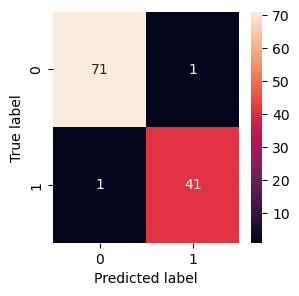

In [81]:
model = LinearSVC()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"LinearSVC \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)

RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



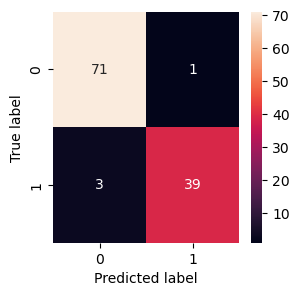

In [83]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"RandomForestClassifier \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)

LogisticRegression 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



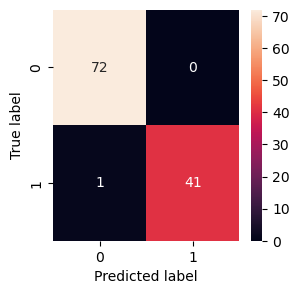

In [82]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"LogisticRegression \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)